In [1]:
# init
import math
import os
import numpy as np
from numpy import fft
import cv2
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 仿真运动模糊
def motion_process(image_size, motion_angle):
    PSF = np.zeros(image_size)
    center_position = (image_size[0] - 1) / 2
    slope_tan = math.tan(motion_angle * math.pi / 180)
    slope_cot = 1 / slope_tan
    if slope_tan <= 1:
        for i in range(15):
            offset = round(i * slope_tan)  # ((center_position-i)*slope_tan)
            PSF[int(center_position + offset), int(center_position - offset)] = 1
        return PSF / PSF.sum()  # 对点扩散函数进行归一化亮度
    else:
        for i in range(15):
            offset = round(i * slope_cot)
            PSF[int(center_position - offset), int(center_position + offset)] = 1
        return PSF / PSF.sum()

In [3]:
# 对图片进行运动模糊
def make_blurred(input, PSF, eps):
    input_fft = fft.fft2(input)  # 进行二维数组的傅里叶变换
    PSF_fft = fft.fft2(PSF) + eps
    blurred = fft.ifft2(input_fft * PSF_fft)
    blurred = np.abs(fft.fftshift(blurred))
    return blurred

In [4]:
# 逆滤波
def inverse(input, PSF, eps):
    input_fft = fft.fft2(input)
    PSF_fft = fft.fft2(PSF) + eps  # 噪声功率，这是已知的，考虑epsilon
    result = fft.ifft2(input_fft / PSF_fft)  # 计算F(u,v)的傅里叶反变换
    result = np.abs(fft.fftshift(result))
    return result

In [5]:
# 维纳滤波，K=0.01
def wiener(input, PSF, eps, K=0.01):
    input_fft = fft.fft2(input)
    PSF_fft = fft.fft2(PSF) + eps
    PSF_fft_1 = np.conj(PSF_fft) / (np.abs(PSF_fft) ** 2 + K)
    result = fft.ifft2(input_fft * PSF_fft_1)
    result = np.abs(fft.fftshift(result))
    return result

In [9]:
def put(path):
    img = cv2.imread(path, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_h = img.shape[0]
    img_w = img.shape[1]
    # 进行运动模糊处理
    PSF = motion_process((img_h, img_w), 60)

    blurred = np.abs(make_blurred(img, PSF, 1e-3))
    # 逆滤波
    res1 = inverse(blurred, PSF, 1e-3)
    # 维纳滤波
    res2 = wiener(blurred, PSF, 1e-3)

    # 添加噪声,standard_normal产生随机的函数
    blurred_noisy = blurred + 0.1 * blurred.std() * np.random.standard_normal(blurred.shape)
    # 对添加噪声的图像进行逆滤波
    res3 = inverse(blurred_noisy, PSF, 0.2 + 1e-3)
    # 对添加噪声的图像进行维纳滤波
    res4 = wiener(blurred_noisy, PSF, 0.2 + 1e-3)
    plt.subplot(3, 4, 1), plt.axis('off'), plt.imshow(img, plt.cm.gray), plt.title(' 原图')
    plt.subplot(3, 4, 2), plt.axis('off'), plt.imshow(blurred, plt.cm.gray), plt.title('运动模糊')
    plt.subplot(3, 4, 3), plt.axis('off'), plt.imshow(res1, plt.cm.gray), plt.title(' 逆滤波')
    plt.subplot(3, 4, 4), plt.axis('off'), plt.imshow(res2, plt.cm.gray), plt.title(' 维纳滤波(k=0.01)')
    plt.subplot(3, 4, 5), plt.axis('off'), plt.imshow(img, plt.cm.gray), plt.title(' 原图')
    plt.subplot(3, 4, 6), plt.axis('off'), plt.imshow(blurred_noisy, plt.cm.gray), plt.title('有噪声且运动模糊')
    plt.subplot(3, 4, 7), plt.axis('off'), plt.imshow(res3, plt.cm.gray), plt.title(' 逆滤波')
    plt.subplot(3, 4, 8), plt.axis('off'), plt.imshow(res4, plt.cm.gray), plt.title(' 维纳滤波(k=0.01)')
    plt.subplot(3, 4, 9), plt.axis('off'), plt.imshow(img, plt.cm.gray), plt.title("原图")"
    

    # plt.savefig('3.new.jpg')
    plt.show()

SyntaxError: unterminated string literal (detected at line 29) (2226986799.py, line 29)

In [8]:
def gaussian(img):
    return GaussianBlur(img, ksize=(9,9), sigmaX=0, sigmaY=0)

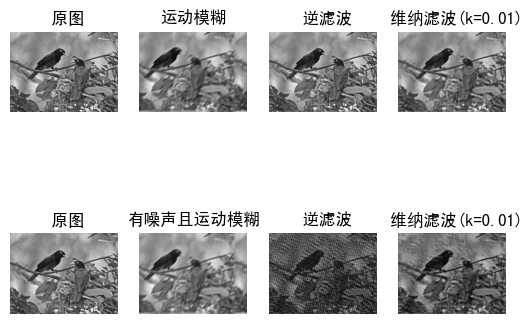

In [7]:
if __name__ == "__main__":
    put("OIP-C.jpg")